# Introducción a Clusterización

La clusterización (clustering) es una técnica de **aprendizaje no supervisado** que agrupa datos similares en conjuntos llamados clusters. A diferencia del aprendizaje supervisado, no tenemos etiquetas predefinidas.

## ¿Para qué sirve?

- **Segmentación de clientes**: Agrupar clientes con comportamientos similares
- **Detección de anomalías**: Identificar datos que no pertenecen a ningún grupo
- **Compresión de imágenes**: Reducir colores agrupando píxeles similares
- **Organización de documentos**: Agrupar textos por temas

## Algoritmos que veremos

1. **K-Means**: El más popular, agrupa por distancia a centroides
2. **DBSCAN**: Clustering basado en densidad, detecta formas irregulares
3. **Clustering Jerárquico**: Crea una jerarquía de clusters

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons, load_iris
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Semilla para reproducibilidad
np.random.seed(42)

---
## Ejemplo 1: K-Means - Datos Sintéticos

K-Means es un algoritmo iterativo que:
1. Inicializa K centroides aleatoriamente
2. Asigna cada punto al centroide más cercano
3. Recalcula los centroides como el promedio de los puntos asignados
4. Repite hasta convergencia

### Visualización del Proceso Iterativo de K-Means

Antes de aplicar K-Means con scikit-learn, veamos cómo funciona el algoritmo paso a paso con k=2.

Convergencia alcanzada en la iteración 3
Número total de iteraciones: 3


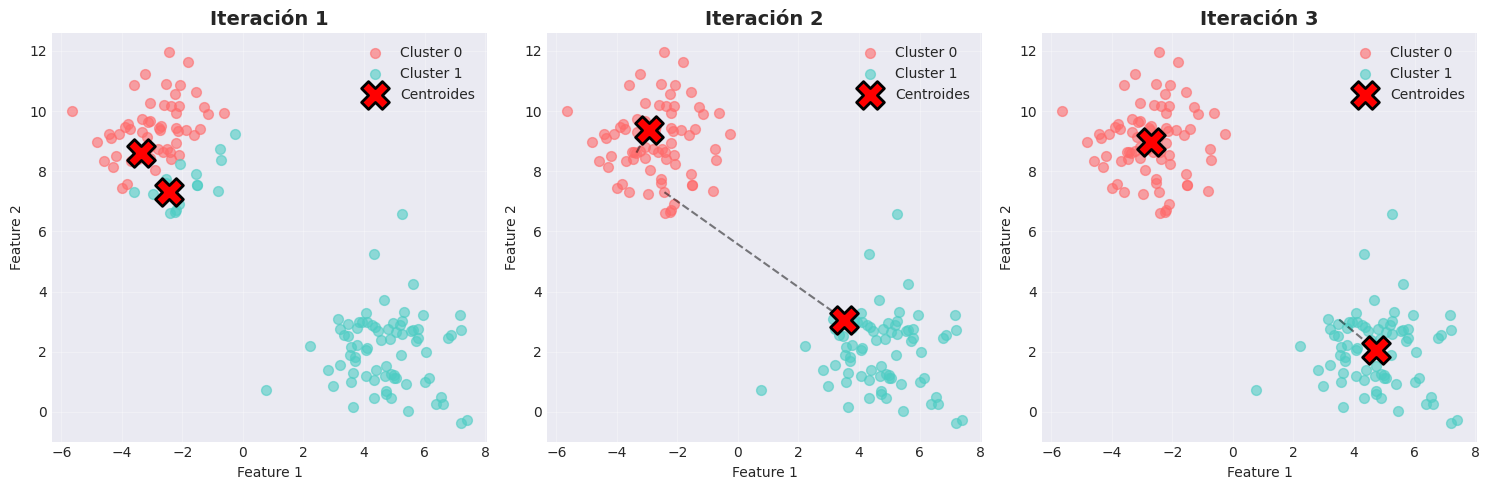


Centroides finales:
[[-2.70957555  8.9789996 ]
 [ 4.73889369  2.04221531]]

Inercia final: 411.33


In [2]:
# Generar datos simples para visualización
np.random.seed(42)
X_demo, _ = make_blobs(n_samples=150, centers=2, n_features=2, 
                       cluster_std=1.2, random_state=42)

# Función para calcular distancias euclidianas
def calcular_distancias(X, centroides):
    """Calcula la distancia de cada punto a cada centroide"""
    distancias = np.zeros((X.shape[0], centroides.shape[0]))
    for i, centroide in enumerate(centroides):
        distancias[:, i] = np.sqrt(np.sum((X - centroide)**2, axis=1))
    return distancias

# Función para asignar clusters
def asignar_clusters(X, centroides):
    """Asigna cada punto al centroide más cercano"""
    distancias = calcular_distancias(X, centroides)
    return np.argmin(distancias, axis=1)

# Función para actualizar centroides
def actualizar_centroides(X, labels, k):
    """Calcula los nuevos centroides como el promedio de cada cluster"""
    centroides = np.zeros((k, X.shape[1]))
    for i in range(k):
        puntos_cluster = X[labels == i]
        if len(puntos_cluster) > 0:
            centroides[i] = puntos_cluster.mean(axis=0)
    return centroides

# Implementación manual de K-Means con k=2
k = 2
max_iters = 6

# Inicializar centroides aleatoriamente
indices_iniciales = np.random.choice(X_demo.shape[0], k, replace=False)
centroides = X_demo[indices_iniciales]

# Almacenar el historial
historial_centroides = [centroides.copy()]
historial_labels = []

# Algoritmo iterativo
for iteracion in range(max_iters):
    # Paso 1: Asignar cada punto al centroide más cercano
    labels = asignar_clusters(X_demo, centroides)
    historial_labels.append(labels.copy())
    
    # Paso 2: Actualizar centroides
    nuevos_centroides = actualizar_centroides(X_demo, labels, k)
    
    # Verificar convergencia
    if np.allclose(centroides, nuevos_centroides):
        print(f"Convergencia alcanzada en la iteración {iteracion + 1}")
        centroides = nuevos_centroides
        historial_centroides.append(centroides.copy())
        break
    
    centroides = nuevos_centroides
    historial_centroides.append(centroides.copy())

print(f"Número total de iteraciones: {len(historial_labels)}")

# Visualizar cada iteración
n_plots = len(historial_labels)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_plots > 1 else [axes]

colores = ['#FF6B6B', '#4ECDC4']

for idx, (labels, centroides_iter) in enumerate(zip(historial_labels, historial_centroides[:-1])):
    ax = axes[idx]
    
    # Graficar puntos coloreados por cluster
    for cluster_id in range(k):
        mask = labels == cluster_id
        ax.scatter(X_demo[mask, 0], X_demo[mask, 1], 
                  c=colores[cluster_id], alpha=0.6, s=50, 
                  label=f'Cluster {cluster_id}')
    
    # Graficar centroides
    ax.scatter(centroides_iter[:, 0], centroides_iter[:, 1], 
              c='red', marker='X', s=400, edgecolors='black', 
              linewidths=2, label='Centroides', zorder=5)
    
    # Graficar líneas desde centroides anteriores (si existe)
    if idx > 0:
        centroides_anterior = historial_centroides[idx - 1]
        for i in range(k):
            ax.plot([centroides_anterior[i, 0], centroides_iter[i, 0]],
                   [centroides_anterior[i, 1], centroides_iter[i, 1]],
                   'k--', alpha=0.5, linewidth=1.5)
    
    ax.set_title(f'Iteración {idx + 1}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

# Ocultar ejes sobrantes
for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Mostrar centroides finales
print("\nCentroides finales:")
print(historial_centroides[-1])

# Calcular inercia final
labels_final = historial_labels[-1]
inercia = 0
for i in range(k):
    puntos_cluster = X_demo[labels_final == i]
    inercia += np.sum((puntos_cluster - historial_centroides[-1][i])**2)
print(f"\nInercia final: {inercia:.2f}")

**Observaciones clave:**

- **Iteración 1**: Los centroides se inicializan en posiciones aleatorias
- **Iteraciones siguientes**: Los centroides se mueven (líneas punteadas) hacia el centro de los puntos asignados
- **Convergencia**: El algoritmo termina cuando los centroides ya no se mueven significativamente
- **Resultado final**: Los centroides representan el "centro" de cada cluster

Este proceso demuestra por qué K-Means es sensible a la inicialización y puede converger a diferentes soluciones dependiendo de dónde comiencen los centroides.

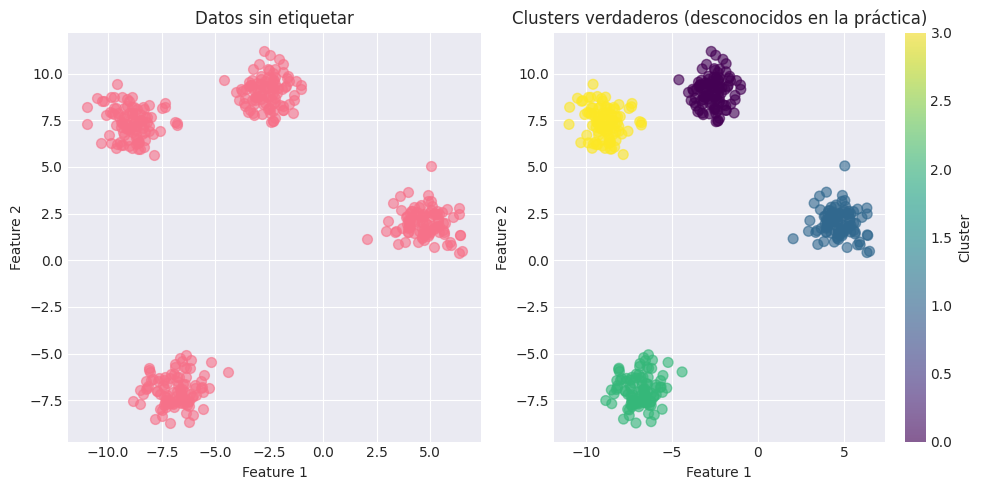

Forma de los datos: (400, 2)


In [3]:
# Generar datos sintéticos con 4 clusters bien definidos
X_blobs, y_true = make_blobs(n_samples=400, centers=4, n_features=2, 
                              cluster_std=0.8, random_state=42)

# Visualizar los datos originales
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], alpha=0.6, s=50)
plt.title('Datos sin etiquetar')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_true, cmap='viridis', alpha=0.6, s=50)
plt.title('Clusters verdaderos (desconocidos en la práctica)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

print(f"Forma de los datos: {X_blobs.shape}")

### Aplicando K-Means

### Métricas de Evaluación de Clustering

Como no tenemos etiquetas verdaderas en clustering, necesitamos métricas que evalúen la calidad de los clusters basándose en:
1. **Cohesión**: Qué tan compactos son los clusters internamente
2. **Separación**: Qué tan separados están los clusters entre sí

#### 1. Inercia (Within-Cluster Sum of Squares - WCSS)

**Definición matemática:**

$$\text{Inercia} = \sum_{i=1}^{K} \sum_{x \in C_i} \|x - \mu_i\|^2$$

Donde:
- $K$ = número de clusters
- $C_i$ = conjunto de puntos en el cluster $i$
- $x$ = un punto de datos
- $\mu_i$ = centroide del cluster $i$
- $\|x - \mu_i\|^2$ = distancia euclidiana al cuadrado

**Interpretación intuitiva:**

La inercia mide qué tan compactos son los clusters. Imagina que cada punto está conectado a su centroide por un resorte - la inercia sería la energía total almacenada en todos esos resortes.

- **Valor más bajo** = clusters más compactos (mejor)
- **Valor más alto** = puntos más dispersos del centroide
- **Problema**: Siempre disminuye al aumentar K (con K=n, inercia=0)

Por eso usamos el **método del codo**: buscamos el punto donde la inercia deja de disminuir significativamente.

---

#### 2. Silhouette Score

**Definición matemática:**

Para cada punto $i$:

$$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

Donde:
- $a(i)$ = distancia promedio de $i$ a todos los demás puntos en su mismo cluster (cohesión)
- $b(i)$ = distancia promedio de $i$ a todos los puntos del cluster más cercano (separación)

El Silhouette Score es el promedio de $s(i)$ sobre todos los puntos.

**Interpretación intuitiva:**

El silhouette score mide qué tan bien está asignado cada punto a su cluster. Para cada punto pregunta:

- "¿Estoy más cerca de los puntos de mi cluster o del cluster vecino?"

**Valores:**
- **+1**: El punto está muy bien asignado (lejos de otros clusters)
- **0**: El punto está en la frontera entre dos clusters
- **-1**: El punto probablemente está en el cluster equivocado

**Ventajas:**
- Rango acotado [-1, 1], fácil de interpretar
- Considera tanto cohesión como separación
- No depende del número de clusters

---

#### 3. Davies-Bouldin Index

**Definición matemática:**

$$DB = \frac{1}{K} \sum_{i=1}^{K} \max_{j \neq i} \left( \frac{s_i + s_j}{d(c_i, c_j)} \right)$$

Donde:
- $s_i$ = distancia promedio de todos los puntos en el cluster $i$ a su centroide $c_i$
- $d(c_i, c_j)$ = distancia entre los centroides $i$ y $j$

**Interpretación intuitiva:**

El índice Davies-Bouldin mide la "similitud" promedio entre cada cluster y su cluster más parecido. Para cada cluster pregunta:

- "¿Qué tan disperso estoy internamente comparado con qué tan lejos está mi vecino más cercano?"

Piensa en clusters como grupos de personas:
- **Numerador grande** ($s_i + s_j$): Los grupos están muy dispersos internamente
- **Denominador grande** ($d(c_i, c_j)$): Los centros de los grupos están muy separados
- **Queremos**: Grupos compactos (numerador pequeño) y bien separados (denominador grande)

**Valores:**
- **Valor más bajo** = mejor clustering
- **0** = mejor valor posible (clusters perfectamente separados y compactos)
- **Sin límite superior**: puede crecer indefinidamente

---

#### Comparación de las métricas

| Métrica | Rango | Mejor valor | Ventaja principal | Desventaja |
|---------|-------|-------------|-------------------|------------|
| **Inercia** | [0, ∞) | Más bajo | Simple de calcular | Siempre disminuye con más K |
| **Silhouette** | [-1, 1] | Cercano a 1 | Intuitivo, considera separación | Costoso computacionalmente |
| **Davies-Bouldin** | [0, ∞) | Cercano a 0 | Penaliza clusters mal separados | Asume clusters convexos |

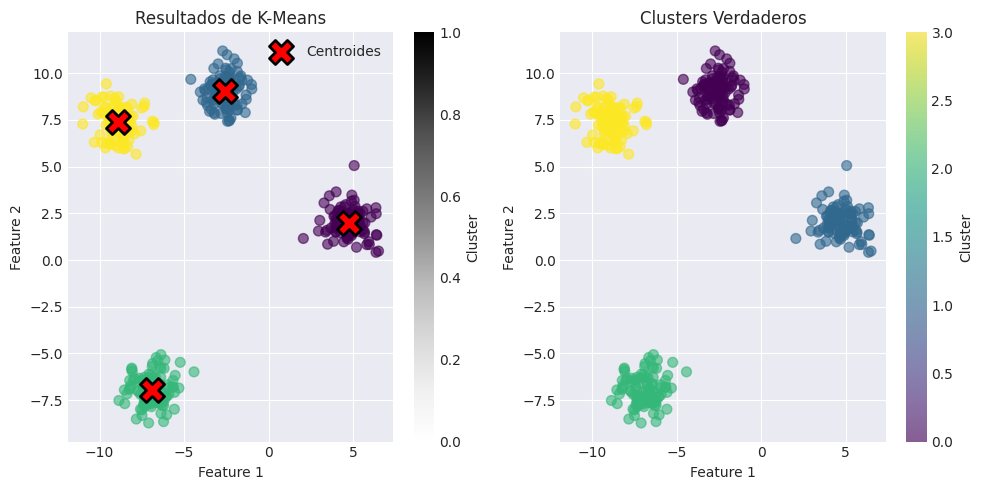


Métricas de evaluación:
Silhouette Score: 0.835 (rango: [-1, 1], mejor: cercano a 1)
Davies-Bouldin Index: 0.231 (mejor: cercano a 0)
Inercia (suma de distancias al cuadrado): 490.57


In [4]:
# Aplicar K-Means con k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_blobs)

# Visualizar resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_kmeans, cmap='viridis', alpha=0.6, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=300, edgecolors='black', linewidths=2, label='Centroides')
plt.title('Resultados de K-Means')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.colorbar(label='Cluster')

plt.subplot(1, 2, 2)
# Comparación con clusters verdaderos
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_true, cmap='viridis', alpha=0.6, s=50)
plt.title('Clusters Verdaderos')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# Métricas de evaluación
silhouette = silhouette_score(X_blobs, y_kmeans)
davies_bouldin = davies_bouldin_score(X_blobs, y_kmeans)

print(f"\nMétricas de evaluación:")
print(f"Silhouette Score: {silhouette:.3f} (rango: [-1, 1], mejor: cercano a 1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (mejor: cercano a 0)")
print(f"Inercia (suma de distancias al cuadrado): {kmeans.inertia_:.2f}")

### ¿Cómo elegir el número de clusters (K)?

El **método del codo** nos ayuda a encontrar el K óptimo observando dónde la inercia deja de disminuir significativamente.

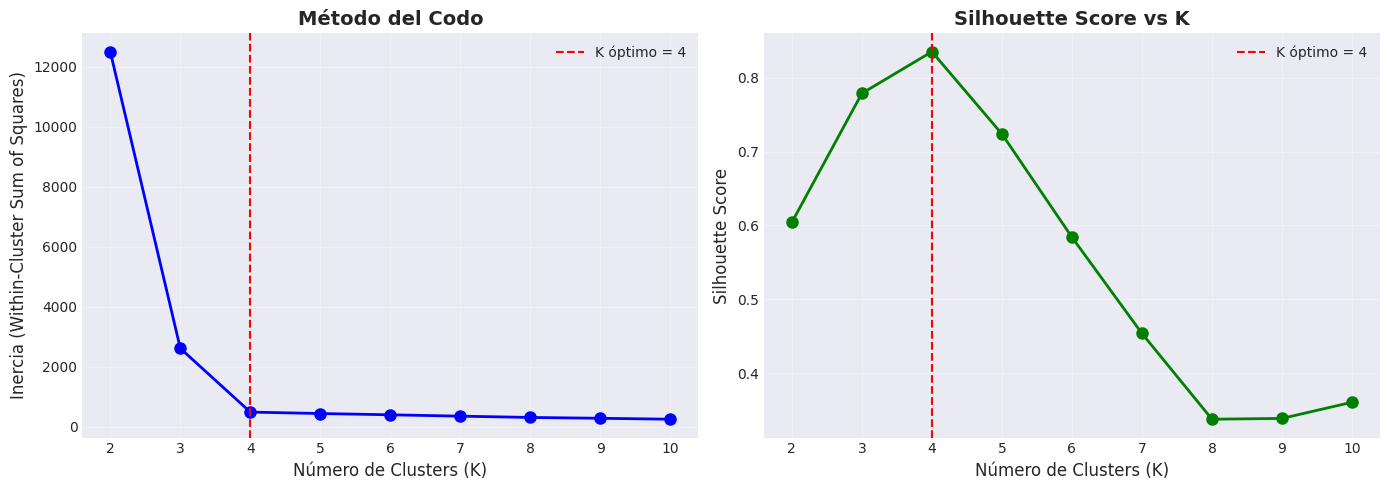


Observaciones:
- El 'codo' está en K=4, donde la inercia empieza a disminuir más lentamente
- El Silhouette Score es máximo en K=4, confirmando que es el mejor número de clusters


In [5]:
# Método del codo
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_blobs)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_blobs, kmeans_temp.labels_))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del codo
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=4, color='red', linestyle='--', label='K óptimo = 4')
axes[0].legend()

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=4, color='red', linestyle='--', label='K óptimo = 4')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nObservaciones:")
print("- El 'codo' está en K=4, donde la inercia empieza a disminuir más lentamente")
print("- El Silhouette Score es máximo en K=4, confirmando que es el mejor número de clusters")

---
## Ejemplo 2: K-Means con Dataset Real (Iris)

Usaremos el famoso dataset Iris para segmentar flores según sus características.

In [6]:
# Cargar dataset Iris
iris = load_iris()
X_iris = iris.data
y_iris_true = iris.target
feature_names = iris.feature_names

# Crear DataFrame para mejor visualización
df_iris = pd.DataFrame(X_iris, columns=feature_names)
df_iris['especie'] = pd.Categorical.from_codes(y_iris_true, iris.target_names)

print("Primeras filas del dataset Iris:")
print(df_iris.head(10))
print(f"\nForma: {df_iris.shape}")
print(f"\nEspecies: {iris.target_names}")

Primeras filas del dataset Iris:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   
5                5.4               3.9                1.7               0.4   
6                4.6               3.4                1.4               0.3   
7                5.0               3.4                1.5               0.2   
8                4.4               2.9                1.4               0.2   
9                4.9               3.1                1.5               0.1   

  especie  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  
5  setosa  
6  setosa  
7

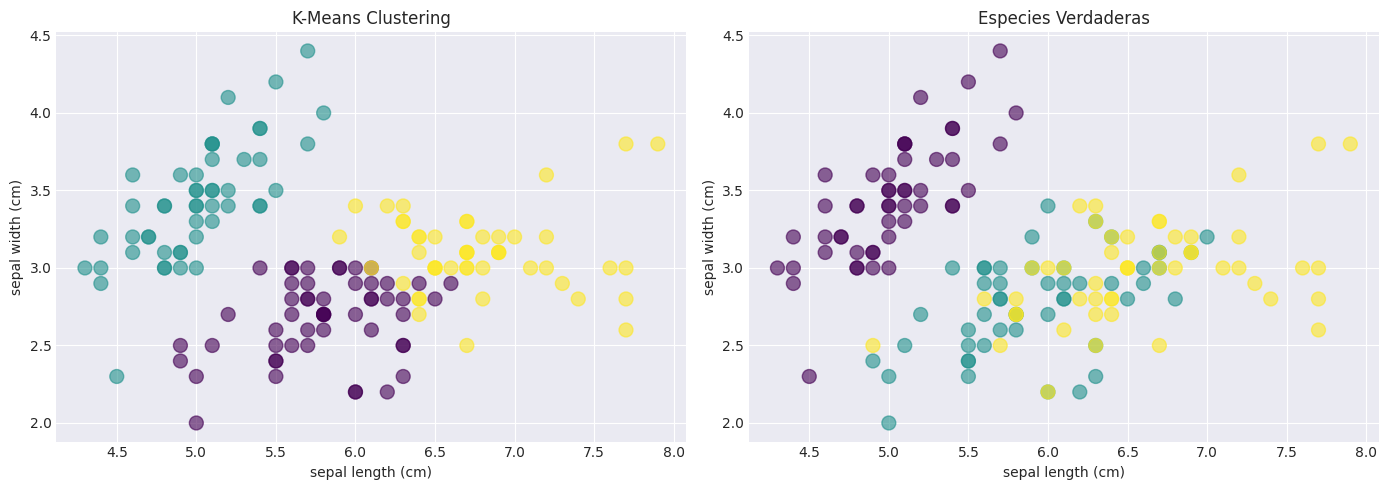


Silhouette Score: 0.460

Tabla de contingencia (Especies vs Clusters):
Cluster        0   1   2
Especie Real            
setosa         0  50   0
versicolor    39   0  11
virginica     14   0  36


In [7]:
# Normalizar los datos (importante para K-Means)
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Aplicar K-Means con k=3 (sabemos que hay 3 especies)
kmeans_iris = KMeans(n_clusters=3, random_state=42, n_init=10)
y_iris_pred = kmeans_iris.fit_predict(X_iris_scaled)

# Visualizar usando las dos primeras características
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clustering predicho
axes[0].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris_pred, cmap='viridis', alpha=0.6, s=100)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].set_title('K-Means Clustering')

# Especies verdaderas
axes[1].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris_true, cmap='viridis', alpha=0.6, s=100)
axes[1].set_xlabel(feature_names[0])
axes[1].set_ylabel(feature_names[1])
axes[1].set_title('Especies Verdaderas')

plt.tight_layout()
plt.show()

# Evaluación
silhouette_iris = silhouette_score(X_iris_scaled, y_iris_pred)
print(f"\nSilhouette Score: {silhouette_iris:.3f}")

# Comparar clusters con especies reales
df_comparison = pd.DataFrame({
    'Especie Real': pd.Categorical.from_codes(y_iris_true, iris.target_names),
    'Cluster': y_iris_pred
})
print("\nTabla de contingencia (Especies vs Clusters):")
print(pd.crosstab(df_comparison['Especie Real'], df_comparison['Cluster']))